In [ ]:
# Sima Siami Namin
# Text Classification using keras and tensorflow


In [1]:
# import some python libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

!sudo pip3 install keras

# this line is needed to enable keras create a variable outside of keras
!pip install tf-nightly


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.compat.v1.keras.layers import CuDNNGRU


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 553.8 MB 16 kB/s 
     |████████████████████████████████| 439 kB 61.5 MB/s 
     |████████████████████████████████| 5.7 MB 40.8 MB/s 
     |████████████████████████████████| 1.7 MB 6.7 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.11.23 which is incompatible.


In [2]:
# loading the content of a train.csv file. You need to upload it using the left panel 
df = pd.read_csv('train.csv')
df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [3]:
# Data inspection: we will be using the "user_review" as text and "user_suggestion" as label 
# we then split these data into train, validation, and test to capture the performance metrics precision, recall, 
# and f1 score, through confusion matrix.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


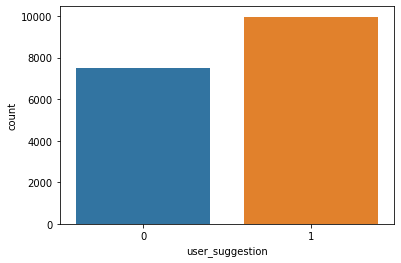

In [4]:
# checking how balance is the dataset and the labels (make sure not having any class imbalance problem)
# the count plot shows the labels are somehow closely balanced 
sns.countplot(df["user_suggestion"])
plt.show()

In [5]:
# Step 1: Cleaning and Lower casing the textual Data
# Dropping unrelevant features and keeping only the two columns one in x and labels in y
userReview = df["user_review"]
userSuggest = df["user_suggestion"]

print(userReview.head())
print(userSuggest.head())

0    I'm scared and hearing creepy voices.  So I'll...
1    Best game, more better than Sam Pepper's YouTu...
2    A littly iffy on the controls, but once you kn...
3    Great game, fun and colorful and all that.A si...
4    Not many games have the cute tag right next to...
Name: user_review, dtype: object
0    1
1    1
2    1
3    1
4    1
Name: user_suggestion, dtype: int64


In [6]:
# A function to clean the text, lower all alphabet, keeping only alphanumerical characters 
# and removing all other characters including punctuations, etc.
def cleanTexts(texts):
    cleaned = []
    pattern = "[^a-zA-Z0-9]"
    for text in texts:
        clrd = re.sub(pattern," ",text).lower().strip()
        cleaned.append(clrd)
    return cleaned



In [7]:
# a test case to test the function developed 
cleanTexts(["I am having dinner at 8:30 with my close friends tonight!! Are you coming with me?"])


['i am having dinner at 8 30 with my close friends tonight   are you coming with me']

In [8]:
# lets clean out input data: x (user_review)
userReview_cleaned = cleanTexts(userReview)

print(userReview_cleaned[0])

i m scared and hearing creepy voices   so i ll pause for a moment and write a review while i wait for my heart beat to return to atleast somewhat calmer times   this game is adorable and creepy like my happy tree friends but with the graphics sceme of my childhood  but more bubble and  clean     hello 1990 s what charactes there are  that isnot trying to kill me  were likable and a bit odd   i did do a few noob things though  such as oh look a class room full of ghosts from dead children  lets shine my flashlight on them and stand there staring at them  or  hmm creepy music  i ll turn around and see if i can see what s chasing me never before in a game have i been this afraid of finding a locked door


In [9]:
# Step 2: Tokenizing and padding the cleaned data and then vectorize each tokenzied term into a number
# the number is just an index in a dictionary or the result of a word embeding activity. 

# Tokenizer 
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(userReview_cleaned)
userReview_cleaned_tokens = tokenizer.texts_to_sequences(userReview_cleaned)

print(userReview_cleaned_tokens[0])


[7, 127, 2012, 3, 3558, 3152, 3257, 29, 7, 151, 14, 4, 819, 3, 1082, 4, 182, 120, 7, 313, 14, 36, 1472, 1021, 2, 1765, 2, 1534, 1030, 213, 11, 5, 10, 3559, 3, 3152, 27, 36, 922, 610, 184, 15, 16, 1, 171, 9, 36, 3685, 15, 38, 3, 2579, 2923, 19, 63, 37, 17, 13, 267, 2, 244, 56, 179, 3, 4, 206, 2090, 7, 228, 57, 4, 137, 1766, 125, 189, 239, 26, 339, 232, 4, 299, 624, 281, 9, 44, 781, 2266, 846, 3616, 36, 3856, 20, 88, 3, 1045, 37, 39, 88, 33, 3152, 1001, 7, 151, 378, 175, 3, 119, 24, 7, 22, 119, 63, 19, 3506, 56, 173, 148, 12, 4, 5, 18, 7, 108, 11, 2612, 9, 1441, 4, 1138, 1875]


In [10]:
# computing the len of each sentence in the user reviews. 
len_array = [len(s) for s in userReview_cleaned_tokens]
MAX_LEN = int(np.percentile(len_array,.75))
print(MAX_LEN)

13


In [11]:
# now doing the padding, since the reviews are not of the same size 
userReview_cleaned_tokens_pad = pad_sequences(userReview_cleaned_tokens,maxlen=MAX_LEN)
userReview_cleaned_tokens_pad.shape

(17494, 13)

In [12]:
# Step 3: Train Test Splitting into 80 percent for training and 20 percent for testing 

x_train, x_test, y_train, y_test = train_test_split(userReview_cleaned_tokens_pad, 
                                                    np.asarray(userSuggest), test_size=0.2, 
                                                    random_state=42)



In [13]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(13995, 13)
(3499, 13)
(13995,)
(3499,)


In [14]:
# now building the classification model using keras and sequential models with three hidden layers that needs GPUS, 
# one input layer, and one output layer (the dense layer, a sigmoid layer)
# we removed the GPU-based layers
VOCAB_SIZE = len(tokenizer.word_index) + 1
# 1 is added due to padding 

# set the vector size for each word to 100.
VECTOR_SIZE = 100

def buildModel(MAX_LEN,embedding_weights=None):
    
    model = keras.Sequential()
    if embedding_weights is not None:
        model.add(layers.Embedding(input_dim=VOCAB_SIZE,
                                   output_dim=VECTOR_SIZE,
                                   input_length=MAX_LEN,
                                   weights=[embedding_weights],
                                   trainable=True
                              ))
        
    else:
        model.add(layers.Embedding(input_dim=VOCAB_SIZE,
                                   output_dim=VECTOR_SIZE,
                                   input_length=MAX_LEN
                                  ))
    
    #model.add(CuDNNGRU(512,return_sequences=True))
    #model.add(CuDNNGRU(1024,return_sequences=True))
    #model.add(CuDNNGRU(1024,return_sequences=False))

    model.add(layers.Dense(512))
    #model.add(Dropout(0.3))
    model.add(layers.Dense(1024))
    model.add(layers.Dense(1024))

    #model.add(Dropout(0.2))
    model.add(layers.Dense(1,activation="sigmoid"))
    
    # use adam optimizer, binary cross entropy as the loss function, capture 
    model.compile(optimizer="Adam",loss="binary_crossentropy",metrics=["accuracy"])
    return model



In [15]:
model = buildModel(MAX_LEN)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 100)           5192900   
                                                                 
 dense (Dense)               (None, 13, 512)           51712     
                                                                 
 dense_1 (Dense)             (None, 13, 1024)          525312    
                                                                 
 dense_2 (Dense)             (None, 13, 1024)          1049600   
                                                                 
 dense_3 (Dense)             (None, 13, 1)             1025      
                                                                 
Total params: 6,820,549
Trainable params: 6,820,549
Non-trainable params: 0
_________________________________________________________________


In [16]:
# train the model with 20 percent validation
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
model.fit(x_train, y_train, epochs=3, validation_split=0.2)


Epoch 1/3
350/350 [==============================] - 62s 172ms/step - loss: 0.6742 - accuracy: 0.5824 - val_loss: 0.6673 - val_accuracy: 0.5978
Epoch 2/3
350/350 [==============================] - 58s 165ms/step - loss: 0.6580 - accuracy: 0.6066 - val_loss: 0.6685 - val_accuracy: 0.5979
Epoch 3/3
350/350 [==============================] - 63s 179ms/step - loss: 0.6535 - accuracy: 0.6088 - val_loss: 0.6658 - val_accuracy: 0.5978


110/110 [==============================] - 4s 31ms/step
[[[0.56625116]
  [0.55415547]
  [0.4318255 ]
  ...
  [0.56884634]
  [0.6760874 ]
  [0.5652079 ]]

 [[0.5725034 ]
  [0.46369922]
  [0.5725034 ]
  ...
  [0.5725034 ]
  [0.46369922]
  [0.5725034 ]]

 [[0.6185145 ]
  [0.5963964 ]
  [0.7056851 ]
  ...
  [0.60144395]
  [0.51228917]
  [0.53658426]]

 ...

 [[0.5386076 ]
  [0.5386076 ]
  [0.57595414]
  ...
  [0.44905   ]
  [0.56625116]
  [0.52610266]]

 [[0.62997115]
  [0.4931953 ]
  [0.5558878 ]
  ...
  [0.44907862]
  [0.5942075 ]
  [0.47519368]]

 [[0.55097073]
  [0.56625116]
  [0.5550486 ]
  ...
  [0.6185145 ]
  [0.5963964 ]
  [0.835376  ]]]
here 3499
then 3499
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
3499
3499
(3499, 1)
(3499, 1)
2
2
float32
float32
Accuracy score is 54.82% 


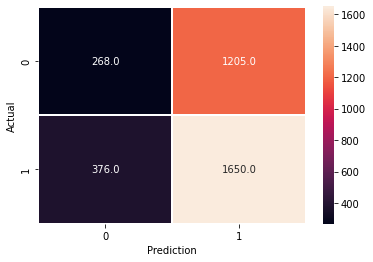

In [17]:
# get the confusion matrix and predictions
y_pred = model.predict(x_test)

print(y_pred)

# keep a threshold of <0.5 as zero and > 0.5 as 1 (binary classification instead of probability scale)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0


# reshape the prediction
#y_test = np.reshape(y_test, (13, 1, ))

y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# retriving the exact number of predictions from the pred (since the output is returning a shape off 13, 1)
y_pred = y_pred[:len(y_test)]

print('here', len(y_pred))
print('then', len(y_test))

print(type(y_pred))
print(type(y_test))

print(y_pred.size)
print(y_test.size)

print(y_pred.shape)
print(y_test.shape)

print(y_pred.ndim)
print(y_test.ndim)

print(y_pred.dtype)
print(y_test.dtype)


accuracy_sc = round(accuracy_score(y_pred=y_pred,y_true=y_test)*100,2)
conf_matrix = confusion_matrix(y_pred=y_pred,y_true=y_test)


print("Accuracy score is {}% ".format(accuracy_sc))

plt.subplots()
sns.heatmap(conf_matrix,annot=True,linewidths=1.5,fmt=".1f")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()


In [21]:
# Saving the model for future use in real time without re-training in a H5 format
model.save('MyTextClassificationModel.h5')


In [22]:
# testing module for re-loading and testing the trained model

# loading the model
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("MyTextClassificationModel.h5")


In [23]:
# retesting the re-constructed model
# get the confusion matrix and predictions
y_pred_usingRecounstructedModel = reconstructed_model.predict(x_test)

print(y_pred_usingRecounstructedModel)

110/110 [==============================] - 4s 31ms/step
[[[0.56625116]
  [0.55415547]
  [0.4318255 ]
  ...
  [0.56884634]
  [0.6760874 ]
  [0.5652079 ]]

 [[0.5725034 ]
  [0.46369922]
  [0.5725034 ]
  ...
  [0.5725034 ]
  [0.46369922]
  [0.5725034 ]]

 [[0.6185145 ]
  [0.5963964 ]
  [0.7056851 ]
  ...
  [0.60144395]
  [0.51228917]
  [0.53658426]]

 ...

 [[0.5386076 ]
  [0.5386076 ]
  [0.57595414]
  ...
  [0.44905   ]
  [0.56625116]
  [0.52610266]]

 [[0.62997115]
  [0.4931953 ]
  [0.5558878 ]
  ...
  [0.44907862]
  [0.5942075 ]
  [0.47519368]]

 [[0.55097073]
  [0.56625116]
  [0.5550486 ]
  ...
  [0.6185145 ]
  [0.5963964 ]
  [0.835376  ]]]
